## Executive Summary

### Goals
To construct a classification model that would accurately predict the programming language that was used in a GitHub repository by scraping their respective readme.md files

### Data
We gathered our data from Github's list of Top Trending Repositories

    - Top Four Languages
         HTML
         JavaScript
         C#
         Python
### Best Model
* Decision Tree Lemmatized TF-IDF  with 62% Accuracy on unseen data

* Baseline was 31%, this shows us the model has value

### Recommendations & Next Steps:

* Recommend using our Decision Tree Lemmatized TF-IDF, it outperforms Baseline of 31% with an accuracy of 62% 

* With more time, we would like to use more repositories to potentially find more words that can help predict the programming language used


### Conclusion

* Our model could accuratley predict the language of the repos by 62% which beats by double the baseline model of 31%. 

* Further cleaning of common words or stop words may improve the accuracy of the model

* C# gave our models the hardest time with misclassifications of every other langauge falling under the C# moniker

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk import sent_tokenize
from prepare import prepare
import seaborn as sns
from wordcloud import WordCloud

In [2]:
with open('data.json') as json_file:
    data = json.load(json_file)

In [3]:
df = pd.DataFrame(data)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             121 non-null    object
 1   language         119 non-null    object
 2   readme_contents  121 non-null    object
dtypes: object(3)
memory usage: 3.0+ KB


In [5]:
df = df[df.language != "Shell"]

In [6]:
df = df[df.language != "Java"]

In [7]:
df = df[df.language != "Ruby"]

In [8]:
df.language = df.language.astype('string')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 120
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             106 non-null    object
 1   language         104 non-null    string
 2   readme_contents  106 non-null    object
dtypes: object(2), string(1)
memory usage: 3.3+ KB


In [10]:
df = df[~df['language'].isnull()]

In [11]:
df.language.value_counts(dropna=False)

HTML          29
C#            27
Python        25
JavaScript    23
Name: language, dtype: Int64

In [12]:
type(df.language[0])

str

In [13]:
df.language.unique()

<StringArray>
['Python', 'JavaScript', 'HTML', 'C#']
Length: 4, dtype: string

# Check out prepare for prepare details

In [14]:
train, validate, test = prepare(df)

In [15]:
train.size, validate.size, test.size

(348, 150, 126)

In [16]:
train.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
63,Asabeneh/30-Days-Of-JavaScript,JavaScript,# 30 Days Of JavaScript\n\n| # Day | ...,30 days javascript day topics 01 introductionr...,30 day javascript day topic 01 introductionrea...,30 day javascript day topic 01 introductionrea...
18,MrS0m30n3/youtube-dl-gui,Python,[![Donations Badge](https://yourdonation.rocks...,donations badgehttpsyourdonationrocksimagesbad...,donat badgehttpsyourdonationrocksimagesbadgesv...,donation badgehttpsyourdonationrocksimagesbadg...
72,statianzo/Fleck,C#,Fleck\r\n===\r\n\r\n[![Build status](https://c...,fleck build statushttpsciappveyorcomapiproject...,fleck build statushttpsciappveyorcomapiproject...,fleck build statushttpsciappveyorcomapiproject...
12,ddbourgin/numpy-ml,Python,# numpy-ml\nEver wish you had an inefficient b...,numpyml ever wish inefficient somewhat legible...,numpyml ever wish ineffici somewhat legibl col...,numpyml ever wish inefficient somewhat legible...
88,mono/CppSharp,C#,CppSharp is a tool and set of libraries which ...,cppsharp tool set libraries facilitates usage ...,cppsharp tool set librari facilit usag nativ c...,cppsharp tool set library facilitates usage na...


# No duplicates

In [17]:
df[df.duplicated()]

,repo,language,readme_contents


# Exploration

In [18]:
def clean(text):
    'A simple function to cleanup text data'
    
    ADDITIONAL_STOPWORDS = []
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [19]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "language")

,n,percent
HTML,29,0.278846
C#,27,0.259615
Python,25,0.240385
JavaScript,23,0.221154


In [20]:
python_words = clean(' '.join(df[df.language == 'Python'].readme_contents))

In [21]:
c_sharp_words = clean(' '.join(df[df.language == 'C#'].readme_contents))

In [22]:
html_words = clean(' '.join(df[df.language == 'HTML'].readme_contents))

In [23]:
javascript_words = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))

In [24]:
java_words = clean(' '.join(df[df.language == 'Java'].readme_contents))

In [25]:
ruby_words = clean(' '.join(df[df.language == 'Ruby'].readme_contents))

In [26]:
shell_words = clean(' '.join(df[df.language == 'Shell'].readme_contents))

### Freq

In [27]:
python_freq = pd.Series(python_words).value_counts()

In [28]:
c_sharp_freq = pd.Series(c_sharp_words).value_counts()

In [29]:
html_freq = pd.Series(html_words).value_counts()

In [30]:
javascript_freq = pd.Series(javascript_words).value_counts()

In [31]:
java_freq = pd.Series(java_words).value_counts()

In [32]:
ruby_freq = pd.Series(ruby_words).value_counts()

In [33]:
shell_freq = pd.Series(shell_words).value_counts()

In [34]:
python_freq.head()

yes        1639
unknown     926
apikey      573
video       489
python      447
dtype: int64

In [35]:
c_sharp_freq.head()

new       192
c         188
use       186
var       185
string    156
dtype: int64

In [36]:
html_freq.head()

html        97
file        76
use         76
15001700    62
dom         51
dtype: int64

In [37]:
javascript_freq.head()

javascript    309
function      276
const         261
1             240
bad           205
dtype: int64

In [38]:
java_freq.head()

Series([], dtype: int64)

### Ruby and Shell only have one observation so we can either drop or go find more

In [39]:
ruby_freq.head()

Series([], dtype: int64)

In [40]:
shell_freq.head()

Series([], dtype: int64)

## Explore on Train

In [41]:
train.head()

,repo,language,readme_contents,clean,stemmed,lemmatized
63,Asabeneh/30-Days-Of-JavaScript,JavaScript,# 30 Days Of JavaScript\n\n| # Day | ...,30 days javascript day topics 01 introductionr...,30 day javascript day topic 01 introductionrea...,30 day javascript day topic 01 introductionrea...
18,MrS0m30n3/youtube-dl-gui,Python,[![Donations Badge](https://yourdonation.rocks...,donations badgehttpsyourdonationrocksimagesbad...,donat badgehttpsyourdonationrocksimagesbadgesv...,donation badgehttpsyourdonationrocksimagesbadg...
72,statianzo/Fleck,C#,Fleck\r\n===\r\n\r\n[![Build status](https://c...,fleck build statushttpsciappveyorcomapiproject...,fleck build statushttpsciappveyorcomapiproject...,fleck build statushttpsciappveyorcomapiproject...
12,ddbourgin/numpy-ml,Python,# numpy-ml\nEver wish you had an inefficient b...,numpyml ever wish inefficient somewhat legible...,numpyml ever wish ineffici somewhat legibl col...,numpyml ever wish inefficient somewhat legible...
88,mono/CppSharp,C#,CppSharp is a tool and set of libraries which ...,cppsharp tool set libraries facilitates usage ...,cppsharp tool set librari facilit usag nativ c...,cppsharp tool set library facilitates usage na...


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 63 to 97
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             58 non-null     object
 1   language         58 non-null     string
 2   readme_contents  58 non-null     object
 3   clean            58 non-null     object
 4   stemmed          58 non-null     object
 5   lemmatized       58 non-null     object
dtypes: object(5), string(1)
memory usage: 3.2+ KB


In [43]:
# looking at the distrubution of languages

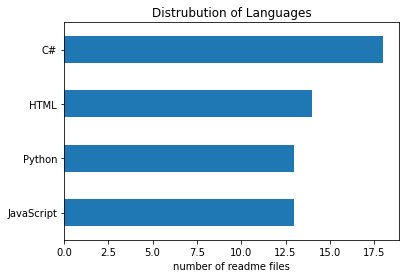

In [44]:
train.language.value_counts().sort_values(ascending = True).plot.barh()
plt.title('Distrubution of Languages')
plt.xlabel('number of readme files')
plt.show()

In [45]:
# same chart, differnt layout

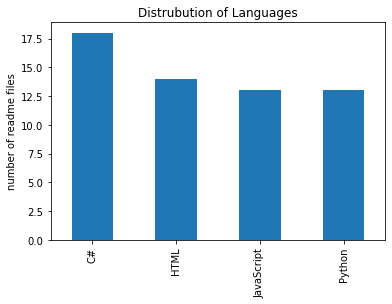

In [46]:
train.language.value_counts().plot.bar()
plt.title('Distrubution of Languages')
plt.ylabel('number of readme files')
plt.show()

In [47]:
#get the list of languages
list_lang = list(train.language.value_counts().index)

In [48]:
#joint all the text of each language
join_text ={}
for language in list_lang :
    join_text[language] = clean(' '.join(train[train.language == language].lemmatized))

#add allwords
join_text['all_words']= clean(' '.join(train.lemmatized))

In [49]:
#check if we have all the languages
join_text.keys()

dict_keys(['C#', 'HTML', 'JavaScript', 'Python', 'all_words'])

In [50]:
#create a word_count df 
word_counts= pd.DataFrame()
for lang in join_text:
    word_counts[lang] = pd.Series(join_text[lang]).value_counts()
word_counts= word_counts.fillna(0).astype(int)

In [51]:
# look at shape of word_counts
word_counts.shape

(3468, 5)

In [52]:
# unique elements of word_count
word_counts.nunique()

C#             53
HTML           24
JavaScript     64
Python         79
all_words     124
dtype: int64

In [53]:
# Lets take a look at the most common words
# Top 10 for all_words

In [54]:
word_counts.sort_values('all_words', ascending=False).head(10)

,C#,HTML,JavaScript,Python,all_words
9,225,236,266,59,786
python,3,1,5,419,428
1,30,7,231,121,389
function,12,3,267,60,342
use,71,39,107,117,334
javascript,5,1,286,4,296
const,1,0,263,0,264
library,21,0,7,205,233
2,19,9,90,112,230
file,16,23,37,152,228


In [55]:
# Top 10 for C#

In [56]:
word_counts.sort_values('C#', ascending=False).head(10)

,C#,HTML,JavaScript,Python,all_words
9,225,236,266,59,786
var,130,5,54,0,189
redis,129,0,0,12,141
new,126,18,40,29,213
csharp,123,0,0,0,123
string,106,4,39,75,224
c,91,20,44,25,180
server,89,3,2,30,124
client,74,9,0,18,101
use,71,39,107,117,334


In [57]:
# Top 10 for HTML

In [58]:
word_counts.sort_values('HTML', ascending=False).head(10)

,C#,HTML,JavaScript,Python,all_words
9,225,236,266,59,786
email,3,40,4,5,52
use,71,39,107,117,334
img,2,28,4,37,71
file,16,23,37,152,228
set,37,20,18,25,100
c,91,20,44,25,180
test,15,19,39,35,108
option,9,19,10,45,83
web,2,18,20,58,98


In [59]:
# Top 10 for JavaScript

In [60]:
word_counts.sort_values('JavaScript', ascending=False).head(10)

,C#,HTML,JavaScript,Python,all_words
javascript,5,1,286,4,296
function,12,3,267,60,342
9,225,236,266,59,786
const,1,0,263,0,264
1,30,7,231,121,389
bad,1,0,203,1,205
link,2,4,195,9,210
good,4,0,190,8,202
return,41,0,126,19,186
foo,6,4,116,0,126


In [61]:
# Top 10 for Python

In [62]:
word_counts.sort_values('Python', ascending=False).head(10)

,C#,HTML,JavaScript,Python,all_words
python,3,1,5,419,428
video,1,0,0,210,211
library,21,0,7,205,233
file,16,23,37,152,228
1,30,7,231,121,389
use,71,39,107,117,334
2,19,9,90,112,230
format,4,2,0,106,112
bot,1,0,0,100,101
download,8,1,3,94,106


In [63]:
# Lets make some word clouds useing the common words found

In [64]:
def word_cloud (text):
    '''
    takes in a text and create a wordcloud
    '''

    plt.figure(figsize=(10,10))
    img = WordCloud(background_color='white', width=800, height=600).generate(text)
    plt.imshow(img)
    plt.axis('off')
    plt.show()


def wordcloud_top(df,column, n_top=50):
    '''
    takes in a df , column and a number of top words to show
    '''
    top_all =df.sort_values(column, ascending=False)[[column]].head(n_top)
    word_cloud(' '.join(top_all.index))


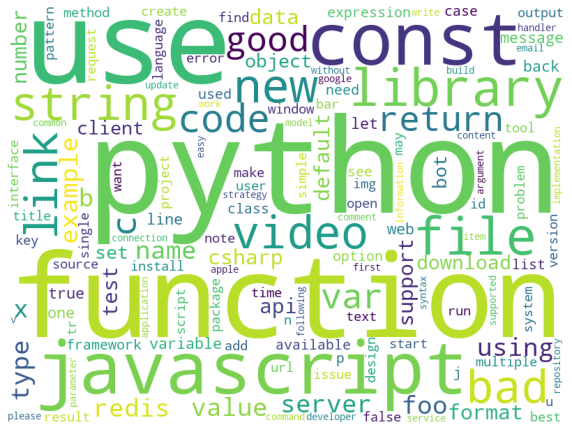

In [65]:
wordcloud_top(word_counts, 'all_words' , 150)

 ********************* Language : C# *********************


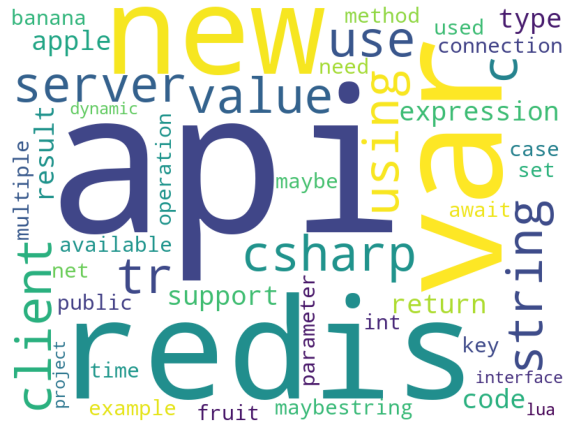

 
 ********************* Language : HTML *********************


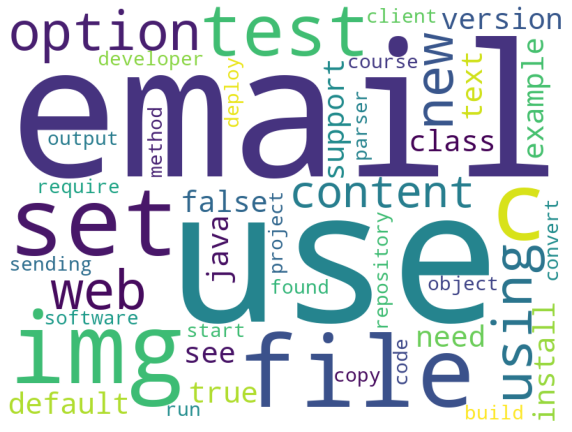

 
 ********************* Language : JavaScript *********************


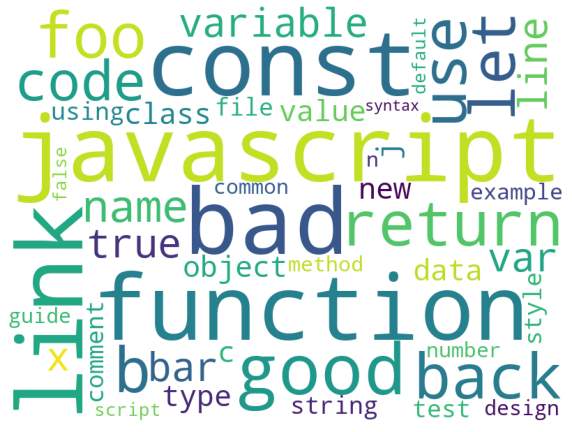

 
 ********************* Language : Python *********************


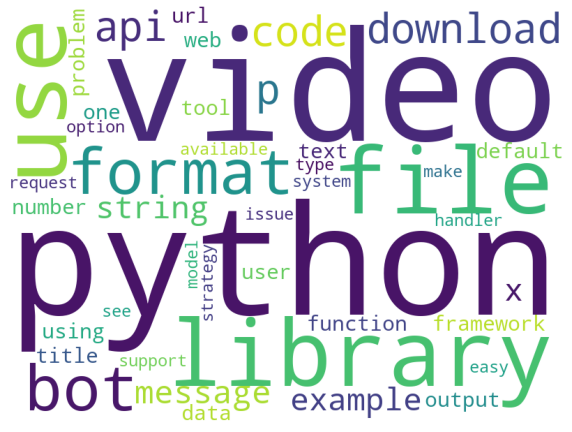

 
 ********************* Language : all_words *********************


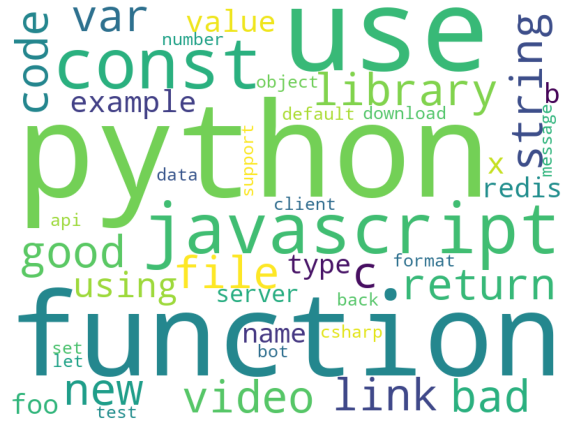

In [66]:
# visualize most frequently occurring words in each language

for col in word_counts.columns:
    print (f' ********************* Language : {col} *********************')
    wordcloud_top(word_counts, col)
    print(' ')

In [67]:
# Chart looking at the most common 20 words

<Figure size 720x576 with 0 Axes>

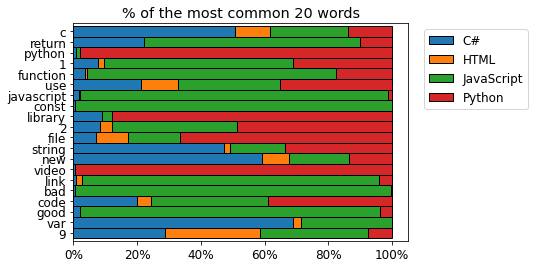

In [68]:
plt.figure(figsize=(10, 8))
plt.rc('font', size=12)
# axis=1 in .apply means row by row
(word_counts.sort_values(by='all_words', ascending=False)
 .head(20)
 .apply(lambda row: row / row['all_words'], axis=1)
 .sort_values(by='all_words')
 .drop(columns='all_words')
 .plot.barh(stacked=True, width=1, ec='black'))
plt.title('% of the most common 20 words')
plt.legend(bbox_to_anchor= (1.03,1))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()

In [69]:
# Charts looking at the most common 20 words each language

<Figure size 720x576 with 0 Axes>

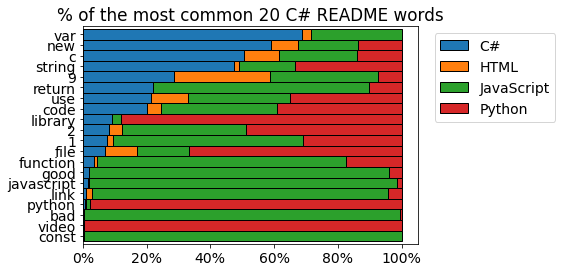

<Figure size 720x576 with 0 Axes>

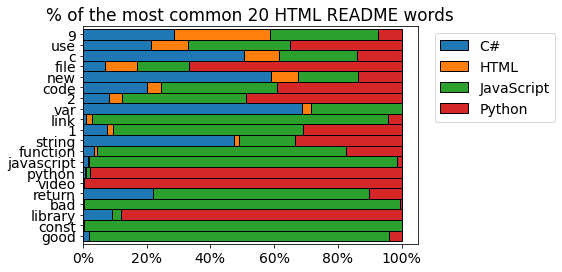

<Figure size 720x576 with 0 Axes>

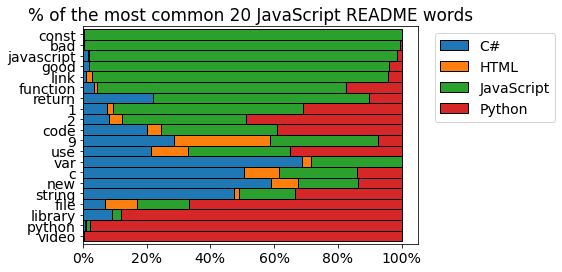

<Figure size 720x576 with 0 Axes>

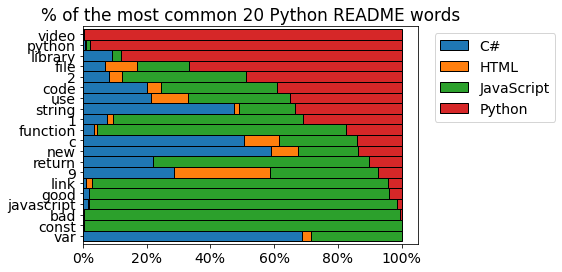

In [70]:
for column in word_counts.drop(columns='all_words'):
    plt.figure(figsize=(10, 8))
    plt.rc('font', size=14)
    # axis=1 in .apply means row by row
    (word_counts.sort_values(by='all_words', ascending=False)
     .head(20)
     .apply(lambda row: row / row['all_words'], axis=1)
     .drop(columns='all_words')
     .sort_values(by= column)
     .plot.barh(stacked=True, width=1, ec='black'))
    plt.title(f'% of the most common 20 {column} README words')
    plt.legend(bbox_to_anchor= (1.03,1))

    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    plt.show()

### Takeaways:

* all_words had most unique elements with 124, followed by Python with 79
* many of the word cross over and are used in each language